# Regression with Fourier Features - Part 2

Initially observed in: https://arxiv.org/abs/2006.10739

The inclusion of Fourier features allows neural networks to capture high frequency information of the target function. In this short note, we compare a vanilla DNN with another Fourier-feature embedded DNN on the task of learning a (noise-perturbed) PDE solution in both space and time domains. The Fourier features embedding is done in both directions and results are aggregated.

This notebook should be self-contained.

In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import scipy
from collections import OrderedDict

# set random seeds
np.random.seed(10)
torch.manual_seed(10);
torch.set_default_dtype(torch.float64)

import numpy as np    
import matplotlib.pyplot as plt

import time
import pylab as pl
from IPython import display
from IPython.display import clear_output

In [80]:
# define vanilla deep neural net
class DNN(torch.nn.Module):
    def __init__(
        self, layers, 
        activation=torch.nn.ReLU, 
        last_layer_activation=None,
        initialization=None
    ):
        """ 
            Custom initialization of neural network layers with the option 
            of changing the output layer's activation function.
            
            The deep net is in space-time.
        """
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = activation
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        if last_layer_activation is not None:
            layer_list.append(
            ('activation_%d' % (self.depth - 1), last_layer_activation())
        )

        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
        # custom initialization modes
        self.initialize(mode=initialization)
        
        
    def forward(self, x):
        return self.layers(x)
    
    def initialize(self, mode):
        if mode == None:
            return
        else:
            for layer in self.layers:
                if isinstance(layer, torch.nn.Linear):
                    # initialize depending on mode
                    if mode == "xavier":
                        torch.nn.init.xavier_uniform_(layer.weight)
                    elif mode == "kaiming":
                        torch.nn.init.kaiming_uniform_(layer.weight)
                    elif mode == "normal":
                        torch.nn.init.normal_(layer.weight)
                    elif mode == "uniform":
                        torch.nn.init.uniform_(layer.weight)
                    elif mode == "ones":
                        torch.nn.init.ones_(layer.weight)
                    else:
                        raise NotImplementedError()
            return
        
class FourierEmbeddedDNN(torch.nn.Module):
    def __init__(self, 
                 layers, 
                 activation=torch.nn.Tanh, 
                 last_layer_activation=None, 
                 initialization=None,
                 m=1,
                 freq_stds=None):
        super(FourierEmbeddedDNN, self).__init__()
        # fourier embedding is applied prior to passing into neural net, 
        # need to make sure dimensions match
        assert layers[0] == 2*m
        # build main DNN
        self.layer_spec = layers
        self.layers = self.build_nn(
            layers, activation, last_layer_activation, initialization
        )
        # build fourier feature embedding
        self.fourier_embedding = self.build_embedding(m, freq_stds)
        
        # build final aggregator to combine outputs of different scale fourier embeddings
        self.build_aggregator()
    
    def build_nn(self, layers, activation, last_layer_activation, initialization):
        self.depth = len(layers) - 1
        # set up layer order dict
        self.activation = activation
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        if last_layer_activation is not None:
            layer_list.append(
            ('activation_%d' % (self.depth - 1), last_layer_activation())
        )

        layerDict = OrderedDict(layer_list)
        return torch.nn.Sequential(layerDict)
    
    def build_embedding(self, num_freqs, freq_stds):
        # number of feature embeddings correspond to length of standard 
        # deviations specified. If `None`, by default uses only 1 embedding
        # standard Gaussian.
        if freq_stds:
            self.num_embeddings = len(freq_stds)
        else:
            self.num_embeddings = 1
            freq_stds = [1.0]
        # draw frequency matrix
        freq_matrix = [torch.randn(num_freqs, requires_grad=False) for _ in range(self.num_embeddings)]
        for i in range(self.num_embeddings):
            # scale by frequency standard deviation
            freq_matrix[i] = torch.tensor(freq_stds[i])*freq_matrix[i]
        return freq_matrix
    
    def build_aggregator(self):
        # number of fourier embeddings
        k = self.num_embeddings
        # size of hidden layer final outputs
        num_out = self.layer_spec[-1]
        # create trainable aggregating weights for each embedding (simple linear aggregation
        # , may also consider computing another nonlinear activation for each embedding, then 
        # summing all outputs).
        self.aggregator = torch.nn.Linear(num_out*k, 1)
        
    def fourier_lifting(self, x, freq):
        # input x has size (N x 1), output has size (N x 2*m) where m is number of Fourier bases
        
        # has size (N x m)
        x = freq * x
        # lift to sin and cos space
        x = torch.concat(
            [
                torch.cos(2*torch.pi*x), 
                torch.sin(2*torch.pi*x)
            ], dim=1
        )
        return x
    
    def forward(self, x):
        # inputs x has size (N x 1)
        # create Fourier features
        lifted = []
        for i in range(self.num_embeddings):
            lifted.append(self.fourier_lifting(x, self.fourier_embedding[i]))
        # lifted is a length-k list of (N x 2*m) tensors of lifted features according to 
        # k different scales.
        
        # now pass each (N x 2*m) features into the hidden layers
        for i in range(self.num_embeddings):
            lifted[i] = self.layers(lifted[i])
        
        # lifted is a length-k list of (N x num_out) tensor of transformed fourier features
        # now concatenate into (N x num_out*k) and pass into aggregator to obtain (N x 1) prediction
        lifted = torch.concat(lifted, dim=1)
        # final aggregation
        lifted = self.aggregator(lifted)
        return lifted

In [81]:
class FourierEmbeddedDNN2d(torch.nn.Module):
    """ 
        A deep neural network suitable for learning space-time functions by stacking
        two separate Fourier embedded nets together and combining the results.

        The spatial and temporal Fourier mappings share the same DNN for hidden transformations.
    """
    def __init__(self, layers, activation=torch.nn.Tanh, 
                 last_layer_activation=None, initialization=None, 
                 m=1, freq_stds=None):
        super(FourierEmbeddedDNN2d, self).__init__()
        # fourier embedding is applied prior to passing into neural net, 
        # need to make sure dimensions match
        assert layers[0] == 2*m
        if freq_stds is not None:
            assert freq_stds.shape[1] == 2, "Specify both space and time frequency scales. "
        else:
            freq_stds = np.ones([1, 2])
        
        # build main DNN
        self.layer_spec = layers
        self.layers = self.build_nn(
            layers, activation, last_layer_activation, initialization
        )
        # build fourier feature embedding
        self.fourier_embedding_time, self.fourier_embedding_space = self.build_embedding(m, freq_stds)
        
        # build final aggregator to combine outputs of different scale fourier embeddings
        self.build_aggregator()
    
    def build_nn(self, layers, activation, last_layer_activation, initialization):
        self.depth = len(layers) - 1
        # set up layer order dict
        self.activation = activation
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        if last_layer_activation is not None:
            layer_list.append(
            ('activation_%d' % (self.depth - 1), last_layer_activation())
        )

        layerDict = OrderedDict(layer_list)
        return torch.nn.Sequential(layerDict)

    def build_embedding(self, num_freqs, freq_stds):
        # number of feature embeddings correspond to length of standard 
        # deviations specified. If `None`, by default uses only 1 embedding
        # standard Gaussian.
        self.num_embeddings = freq_stds.shape[0]
        # time domain scales
        freq_stds_t = freq_stds[:, 0].flatten()
        # spatial domain scales
        freq_stds_x = freq_stds[:, 1].flatten()
        
        # draw frequency matrix (time)
        freq_matrix_t = [torch.randn(num_freqs, requires_grad=False) for _ in range(self.num_embeddings)]
        # draw frequency matrix (space)
        freq_matrix_x = [torch.randn(num_freqs, requires_grad=False) for _ in range(self.num_embeddings)]
        
        for i in range(self.num_embeddings):
            # scale by frequency standard deviation
            freq_matrix_t[i] = torch.tensor(freq_stds_t[i])*freq_matrix_t[i]
            freq_matrix_x[i] = torch.tensor(freq_stds_x[i])*freq_matrix_x[i]
        return freq_matrix_t, freq_matrix_x

    def fourier_lifting(self, x, freq):
        # input x has size (N x 1), output has size (N x 2*m) where m is number of Fourier bases
        
        # has size (N x m)
        x = freq * x
        # lift to sin and cos space
        x = torch.concat(
            [
                torch.cos(2*torch.pi*x), 
                torch.sin(2*torch.pi*x)
            ], dim=1
        )
        return x
    
    def build_aggregator(self):
        # number of fourier embeddings
        k = self.num_embeddings
        # size of hidden layer final outputs
        num_out = self.layer_spec[-1]
        # create trainable aggregating weights for each embedding (simple linear aggregation
        # , may also consider computing another nonlinear activation for each embedding, then 
        # summing all outputs).
        self.aggregator = torch.nn.Linear(num_out*k, 1)
    
    def forward(self, inputs):
        # inputs has size (N x 2)
        # create Fourier features for t
        t = inputs[:, 0][:, None]
        x = inputs[:, 1][:, None]
        
        lifted_t, lifted_x = [], []
        for i in range(self.num_embeddings):
            lifted_t.append(self.fourier_lifting(t, self.fourier_embedding_time[i]))
            lifted_x.append(self.fourier_lifting(x, self.fourier_embedding_space[i]))
            
        # lifted is a length-k list of (N x 2*m) tensors of lifted features according to 
        # k different scales.
        
        # now pass each (N x 2*m) features into the hidden layers
        for i in range(self.num_embeddings):
            lifted_t[i] = self.layers(lifted_t[i])
            lifted_x[i] = self.layers(lifted_x[i])
        
        
        # lifted is a length-k list of (N x num_out) tensor of transformed fourier features
        # now concatenate into (N x num_out*k) and pass into aggregator to obtain (N x 1) prediction
        lifted_t = torch.concat(lifted_t, dim=1)
        lifted_x = torch.concat(lifted_x, dim=1)
        
        # elementwise multiplication
        lifted = lifted_t * lifted_x
        # final aggregation
        lifted = self.aggregator(lifted)
        return lifted
    
# helper
def cartesian_data(x, y):
    """
        Given two 1d arrays of points, return their Carteisan product
        as a list, assuming column-major flattening.
    """
    nx, ny = len(x), len(y)
    y_mesh, x_mesh = torch.meshgrid(y, x, indexing=None)
    x_mesh_flat = x_mesh.ravel().reshape(-1, 1)
    y_mesh_flat = y_mesh.ravel().reshape(-1, 1)
    res = torch.cat(
        [x_mesh_flat, y_mesh_flat], dim=1
    )
    assert len(res) == nx * ny
    return res

Generate data from the following PDE:
$$
    \frac{\partial u}{\partial t} + u_0\sin(\omega t)\frac{\partial u}{\partial x} = 0
$$ whose analytical solution is given by:
$$
    u(t,x) = \exp\bigg(
            -k[x - x_0 - 2v_0\omega^{-1}\sin^2(\frac{1}{2}\omega t)]^2
        \bigg)
$$

In [89]:
# parameters
x0 = 2.0
v0 = 2.0
k = 5.0
omega = 2.0*np.pi
# time grid
t_start = 0.0
t_end = 2*np.pi
dt = 0.001
tgrid = np.arange(t_start, t_end, dt)
nt = len(tgrid)
# spatial grid
x_left, x_right = 0.0, 5.0
dx = 0.005
xgrid = np.arange(x_left, x_right, dx)
nx = len(xgrid)

# solution
u_sol = np.zeros([nt, nx])
for i in range(nt):
    t = tgrid[i]
    u_sol[i, :] = np.exp(-k * (( xgrid - x0 ) - (2*v0/omega) * (np.sin(0.5*omega*t) ** 2)) ** 2 )

# subsample grids
subsample_t = 6
subsample_x = 2
xgrid_small = xgrid.reshape(1, -1)[:, 0:-1:subsample_x].squeeze(),
tgrid_small = tgrid.reshape(1, -1)[:, 0:-1:subsample_t].squeeze()
u_sol_small = u_sol[0:-1:subsample_t, 0:-1:subsample_x]
print(u_sol_small.shape)

(1048, 500)


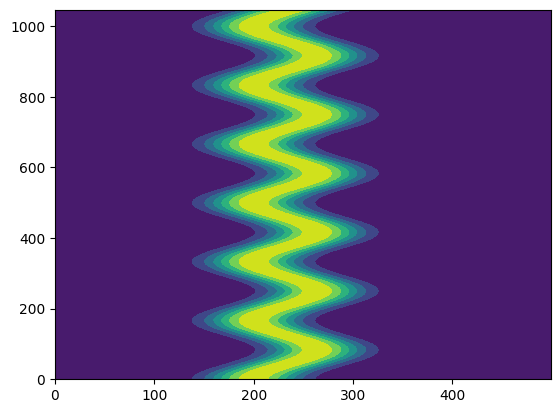

In [90]:
plt.figure(1);
plt.contourf(u_sol_small);

7.8367949999999995


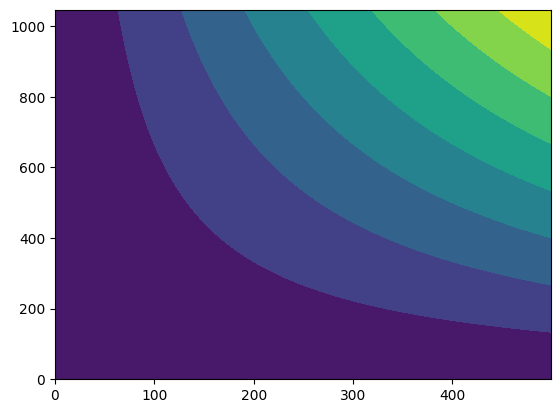

In [96]:
# edit data
u_sol_small2 = xgrid_small[0] * tgrid_small.reshape(-1, 1)
plt.figure(2);
plt.contourf(u_sol_small2)
print(u_sol_small2.mean())

In [102]:
# create training data
X = cartesian_data(torch.tensor(tgrid_small.flatten()), torch.tensor(xgrid_small[0].flatten()))
y = torch.tensor(u_sol_small).T.flatten().reshape(-1, 1)
#y = torch.tensor(u_sol_small2).T.flatten().reshape(-1, 1)

# define training function
def train(inputs, outputs, model, optim, scheduler, batch_size, epochs, shuffle=True):
    X, y = inputs, outputs
    nx = X.shape[0]
    num_batches = int(nx/batch_size)
    for i in range(epochs):
        print("============================================================\n")
        print("Epoch = {}\n".format(i+1));
        print("============================================================\n")
        model.train()
        if shuffle:
            tmp = np.random.permutation(nx)
            X, y = X[tmp, :].data.clone(), y[tmp, :].data.clone()
        for idx in range(num_batches):
            if idx % 100 == 0:
                print("| => | Batch {} |\n".format(idx+1))
        # closure definition
            def closure():
                optim.zero_grad()
                start_idx = idx*batch_size
                end_idx = (idx+1)*batch_size
                if idx + 1 == num_batches:
                    # if last batch
                    end_idx = -1
                Xb, yb = X[start_idx:end_idx, :].data.clone(), y[start_idx:end_idx, :].data.clone()

                # require gradients
                Xb.requires_grad = True
                # make a prediction on the batch
                y_pred = model.forward(Xb)
                # compute L^2 loss
                loss = torch.mean((y_pred - yb)**2)
                # backpropagate
                loss.backward()
                if idx % 100 == 0:
                    print("==> Batch {} loss = {}".format(idx, loss.item()))
                return loss
            optim.step(closure=closure)
        if scheduler:
            # step scheduler after epoch if there is one
            scheduler.step()
            print("---------- \n")
            print("++ Learning rate reduced, now at = {}".format(scheduler.get_last_lr()[0]))

In [103]:
# test vanilla neural net
nn_vanilla = DNN(layers=[2, 128, 128, 128, 1])
optim = torch.optim.Adam(
    nn_vanilla.parameters(),
    lr=8e-3
)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.9999)
train(X, y, nn_vanilla, optim, scheduler, 2**12, 50, shuffle=True)


Epoch = 1


| => | Batch 1 |

==> Batch 0 loss = 0.13258042490901445
| => | Batch 101 |

==> Batch 100 loss = 0.02159527732035612
---------- 

++ Learning rate reduced, now at = 0.0079992

Epoch = 2


| => | Batch 1 |

==> Batch 0 loss = 0.02272904236342077
| => | Batch 101 |

==> Batch 100 loss = 0.019798661617625692
---------- 

++ Learning rate reduced, now at = 0.007998400079999999

Epoch = 3


| => | Batch 1 |

==> Batch 0 loss = 0.0191889183607363
| => | Batch 101 |

==> Batch 100 loss = 0.019118008645620254
---------- 

++ Learning rate reduced, now at = 0.007997600239991999

Epoch = 4


| => | Batch 1 |

==> Batch 0 loss = 0.017829607502557146
| => | Batch 101 |

==> Batch 100 loss = 0.016983152905115987
---------- 

++ Learning rate reduced, now at = 0.007996800479968

Epoch = 5


| => | Batch 1 |

==> Batch 0 loss = 0.016160085133824123
| => | Batch 101 |

==> Batch 100 loss = 0.01692542263321027
---------- 

++ Learning rate reduced, now at = 0.007996000799920003

Epoch = 6

| => | Batch 101 |

==> Batch 100 loss = 0.009434831658444305
---------- 

++ Learning rate reduced, now at = 0.007979225979211954

Epoch = 27


| => | Batch 1 |

==> Batch 0 loss = 0.009930603972153701
| => | Batch 101 |

==> Batch 100 loss = 0.01050402802520705
---------- 

++ Learning rate reduced, now at = 0.007978428056614032

Epoch = 28


| => | Batch 1 |

==> Batch 0 loss = 0.009540915280128862
| => | Batch 101 |

==> Batch 100 loss = 0.008785294087070636
---------- 

++ Learning rate reduced, now at = 0.007977630213808371

Epoch = 29


| => | Batch 1 |

==> Batch 0 loss = 0.008551111569334902
| => | Batch 101 |

==> Batch 100 loss = 0.009308936759520563
---------- 

++ Learning rate reduced, now at = 0.00797683245078699

Epoch = 30


| => | Batch 1 |

==> Batch 0 loss = 0.008602852872245867
| => | Batch 101 |

==> Batch 100 loss = 0.00851623341762519
---------- 

++ Learning rate reduced, now at = 0.007976034767541912

Epoch = 31


| => | Batch 1 |

==> Batch 0 loss = 0.0098409

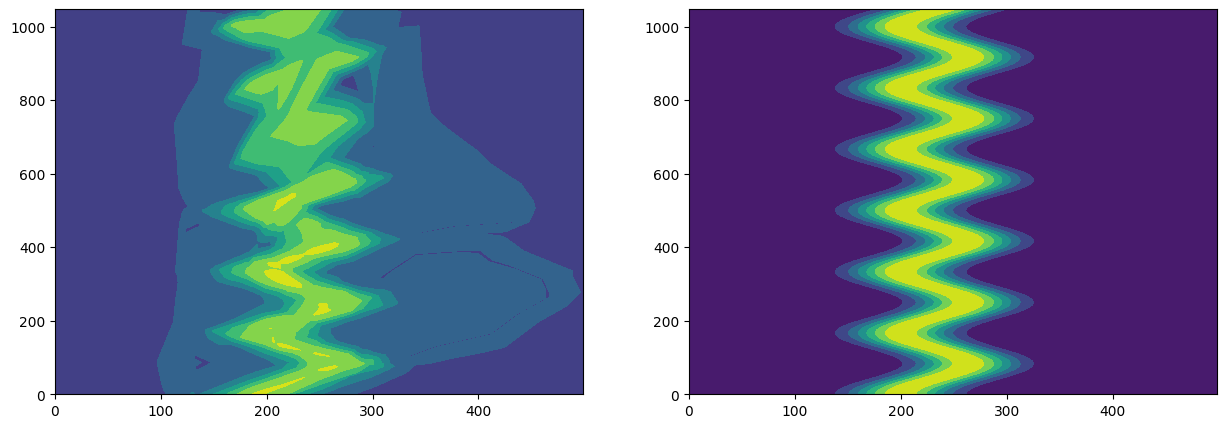

In [104]:
# make predictions and compare contour plots
nt_small = len(tgrid_small.flatten())
nx_small = len(xgrid_small[0].flatten())
u_sol_predict = nn_vanilla(X).reshape([nx_small, nt_small]).detach().numpy().T
u_sol_exact = y.reshape([nx_small, nt_small]).detach().numpy().T

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].contourf(u_sol_predict)
ax[1].contourf(u_sol_exact)

In [111]:
np.mean((u_sol_predict-u_sol_exact)**2)

0.0047743501149463035

In [178]:
# testing Fourier embedded net in 2d
nn_fourier2d = FourierEmbeddedDNN2d(
    layers=[30, 128, 128, 128, 1],
    m=15, 
    freq_stds=np.array([[1.,2.,5.,10.,20.], [1.,1.,1.,1.,1.]]).T
)
optim = torch.optim.Adam(
    nn_fourier2d.parameters(),
    lr=8e-3
)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.9999)
train(X, y, nn_fourier2d, optim, scheduler, 2**11, 50, shuffle=True)


Epoch = 1


| => | Batch 1 |

==> Batch 0 loss = 0.08299804657360897
| => | Batch 101 |

==> Batch 100 loss = 0.019970751332740035
| => | Batch 201 |

==> Batch 200 loss = 0.02310290797677554
---------- 

++ Learning rate reduced, now at = 0.0079992

Epoch = 2


| => | Batch 1 |

==> Batch 0 loss = 0.020983314907505744
| => | Batch 101 |

==> Batch 100 loss = 0.002247063286961674
| => | Batch 201 |

==> Batch 200 loss = 0.001867607590422976
---------- 

++ Learning rate reduced, now at = 0.007998400079999999

Epoch = 3


| => | Batch 1 |

==> Batch 0 loss = 0.0012990115976102075
| => | Batch 101 |

==> Batch 100 loss = 0.0004316592740273668
| => | Batch 201 |

==> Batch 200 loss = 0.00033737798785609795
---------- 

++ Learning rate reduced, now at = 0.007997600239991999

Epoch = 4


| => | Batch 1 |

==> Batch 0 loss = 0.00017832181907427146
| => | Batch 101 |

==> Batch 100 loss = 0.0002479729982273953
| => | Batch 201 |

==> Batch 200 loss = 0.0002154875088284782
---------- 

++ Le

==> Batch 0 loss = 0.0001677075196332762
| => | Batch 101 |

==> Batch 100 loss = 0.0001597162230890916
| => | Batch 201 |

==> Batch 200 loss = 0.00013735031651176618
---------- 

++ Learning rate reduced, now at = 0.00798241846768585

Epoch = 23


| => | Batch 1 |

==> Batch 0 loss = 0.00022721027109993941
| => | Batch 101 |

==> Batch 100 loss = 0.0001830053303939282
| => | Batch 201 |

==> Batch 200 loss = 0.00010499612866761792
---------- 

++ Learning rate reduced, now at = 0.007981620225839082

Epoch = 24


| => | Batch 1 |

==> Batch 0 loss = 0.00016545423088521851
| => | Batch 101 |

==> Batch 100 loss = 0.00018721632280799472
| => | Batch 201 |

==> Batch 200 loss = 0.000210554815107301
---------- 

++ Learning rate reduced, now at = 0.007980822063816497

Epoch = 25


| => | Batch 1 |

==> Batch 0 loss = 0.00017139278431074236
| => | Batch 101 |

==> Batch 100 loss = 0.0001589352627749282
| => | Batch 201 |

==> Batch 200 loss = 0.0001471917132485037
---------- 

++ Learning 

==> Batch 0 loss = 0.00016345598875976193
| => | Batch 101 |

==> Batch 100 loss = 0.00012654287545286184
| => | Batch 201 |

==> Batch 200 loss = 0.00023714181513534845
---------- 

++ Learning rate reduced, now at = 0.007965672141370653

Epoch = 44


| => | Batch 1 |

==> Batch 0 loss = 0.0001579153768211875
| => | Batch 101 |

==> Batch 100 loss = 0.00014659095242370811
| => | Batch 201 |

==> Batch 200 loss = 0.00013416518688640753
---------- 

++ Learning rate reduced, now at = 0.007964875574156515

Epoch = 45


| => | Batch 1 |

==> Batch 0 loss = 0.0002567783563731088
| => | Batch 101 |

==> Batch 100 loss = 0.00019751017734620882
| => | Batch 201 |

==> Batch 200 loss = 0.0001519731991471074
---------- 

++ Learning rate reduced, now at = 0.0079640790865991

Epoch = 46


| => | Batch 1 |

==> Batch 0 loss = 0.00020804501299938728
| => | Batch 101 |

==> Batch 100 loss = 0.00020512613616752753
| => | Batch 201 |

==> Batch 200 loss = 0.00010087108661131468
---------- 

++ Learni

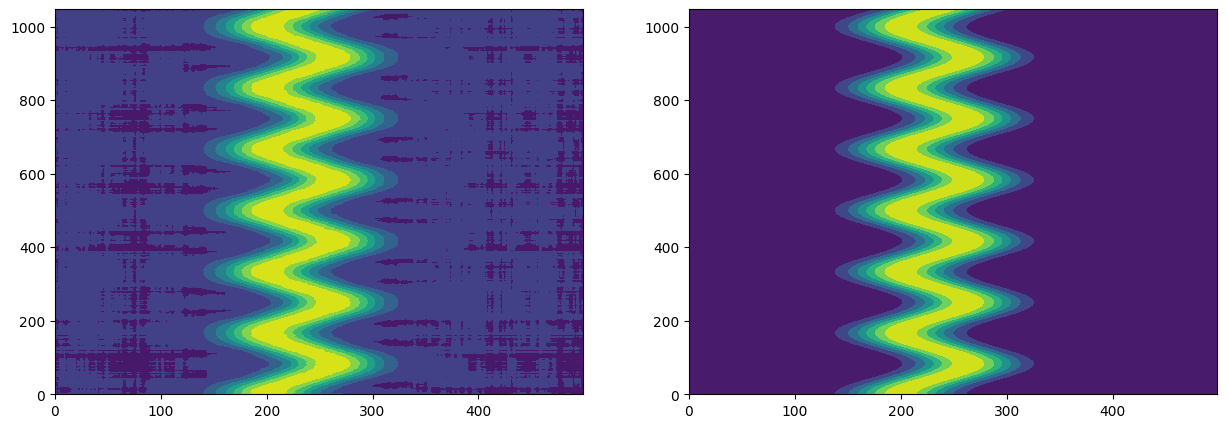

In [179]:
nt_small = len(tgrid_small.flatten())
nx_small = len(xgrid_small[0].flatten())
u_sol_predict_fourier = nn_fourier2d(X).reshape([nx_small, nt_small]).detach().numpy().T
u_sol_exact_fourier = y.reshape([nx_small, nt_small]).detach().numpy().T

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].contourf(u_sol_predict_fourier)
ax[1].contourf(u_sol_exact_fourier)

In [180]:
np.mean((u_sol_predict_fourier-u_sol_exact_fourier)**2)

0.0001146779708527669

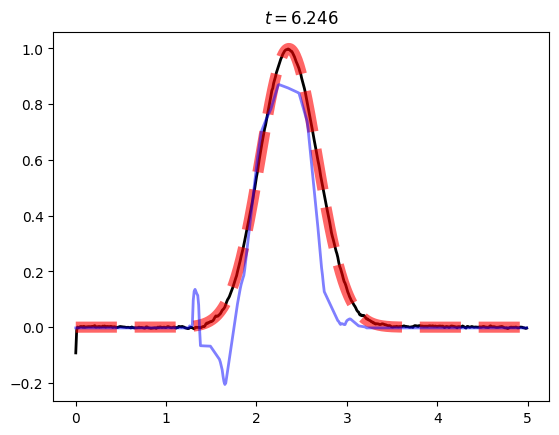

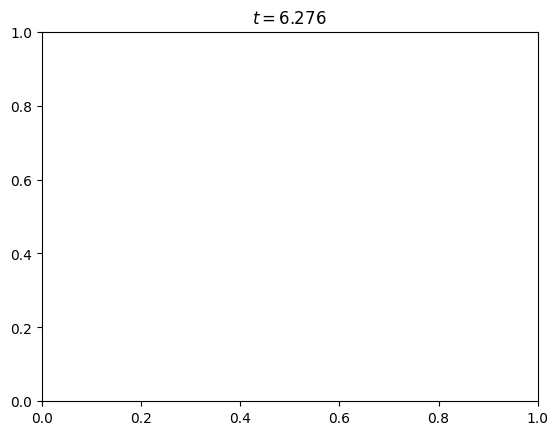

In [182]:
dt = tgrid_small[1]-tgrid_small[0]
for idx in range(nt_small):
    if idx % 5 == 0:
        plt.figure(1);
        plt.plot(xgrid_small[0].flatten(), u_sol_predict_fourier[idx, :], lw=2., color="black");
        plt.plot(xgrid_small[0].flatten(), u_sol_exact_fourier[idx, :], "--", lw=8.0, color="red", alpha=0.6);
        plt.plot(xgrid_small[0].flatten(), u_sol_predict[idx, :], lw=2., color="blue", alpha=0.5);
        display.clear_output(wait=True)
        display.display(pl.gcf())
        plt.clf()
        plt.title(r"$t = {}$".format(dt*(idx+1)))
        time.sleep(0.01);